In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install wget

  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9672 sha256=f3c8dd407d820cbe343a29f36ce78a9317a7d092ee8f7b8d22caaeb1c013ca8e
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget


In [3]:
pip install transformers

     |████████████████████████████████| 2.6 MB 8.1 MB/s 
     |████████████████████████████████| 895 kB 55.3 MB/s 
     |████████████████████████████████| 3.3 MB 56.5 MB/s 
     |████████████████████████████████| 636 kB 57.0 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [4]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
if torch.cuda.is_available():
  device = torch.device('cuda')

  print('there are %d GPU(s) available.' % torch.cuda.device_count())

  print('we will use the GPU: ', torch.cuda.get_device_name(0))

else:
  print("No GPU available, using the CPU instead")
  device = torch.device("cpu")


there are 1 GPU(s) available.
we will use the GPU:  Tesla T4


In [6]:
from transformers import DistilBertTokenizerFast, BertTokenizer
from transformers import TFDistilBertForSequenceClassification, TFDistilBertForTokenClassification

In [7]:
df = pd.read_csv('/content/drive/MyDrive/Kuliah/train sars-cov-2 tw full.csv')

In [8]:
df = df.drop('Unnamed: 2', 1)
#df = df.drop_duplicates()
df.head()

,tweet,sentiment
0,@Namaku_Mei Secara pribadi saya mengakui mayor...,pos
1,Tangan Dokter yang Suntik Vaksin Covid-19 ke P...,netral
2,"Bakal Disuntik Vaksin Covid Perdana di Batam, ...",netral
3,@bebesushi @kopiganja Nope. Vitamin tdk berpen...,netral
4,@TrinityTraveler Padahal upaya untuk mencapai ...,neg


In [9]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords 
import re

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [10]:
from nltk.stem import PorterStemmer
import string

def clean_text(text, remove_stopwords=False, stem_words=False):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = text.lower().split()

    if remove_stopwords:
        stops = set(stopwords.words("indonesian"))
        text = [w for w in text if not w in stops]
    
    text = " ".join(text)

    text = re.sub('@[A-Za-z0-9_]+','',text)
    text = re.sub('#\w+','',text)
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub('\d+', '', text)
    text = re.sub("\s+"," ",text).strip()

    if stem_words:
        text = text.split()
        stemmer = PorterStemmer('indonesian')
        stemmed_words = [stemmer.stem(word) for word in text]
        text = " ".join(stemmed_words)

    return text

def cleaned_text(text):
    #text = text.lower()
    text = text.replace(" utk ", " untuk ")
    text = text.replace(" yg ", " yang ")
    text = text.replace(" dgn ", " dengan ")
    text = text.replace(" dg ", " dengan ")
    text = text.replace(" bs ", " bisa ")
    text = text.replace(" udh ", " sudah ")
    text = text.replace(" udah ", " sudah ")
    text = text.replace(" sdh ", " sudah ")
    text = text.replace(" dah ", " sudah ")
    text = text.replace(" dpt ", " dapat ")
    text = text.replace(" tdk ", " tidak ")
    text = text.replace(" ga ", " enggak ")
    text = text.replace(" gk ", " enggak ")
    text = text.replace(" gak ", " enggak ")
    text = text.replace(" nggak ", " enggak ")
    #text = text.replace(" ga ", " tidak ")
    #text = text.replace(" gk ", " tidak ")
    #text = text.replace(" gak ", " tidak ")
    #text = text.replace(" nggak ", " tidak ")
    text = text.replace(" n ", " dan ")
    text = text.replace(" dos ", " dosis ")
    text = text.replace(" dose ", " dosis ")
    text = text.replace(" kes ", " kasus ")
    text = text.replace(" case ", " kasus ")
    text = text.replace(" y ", " ya ")
    text = text.replace(" iya ", " ya ")
    text = text.replace(" yo ", " ya ")
    text = text.replace(" yaa ", " ya ")
    text = text.replace(" w ", " gue ")
    text = text.replace(" gw ", " gue ")
    text = text.replace(" lu ", " lo ")
    text = text.replace(" kmn ", " kemana ")
    text = text.replace(" mn ", " mana ")
    text = text.replace(" jdi ", " jadi ")
    text = text.replace(" dri ", " dari ")
    text = text.replace(" dr ", " dari ")
    text = text.replace(" kmrn ", " kemarin ")
    text = text.replace(" utk ", " untuk ")
    text = text.replace(" klu ", " kalau ")
    text = text.replace(" klo ", " kalau ")
    text = text.replace(" tpi ", " tetapi ")
    text = text.replace(" tp ", " tetapi ")
    text = text.replace(" ttp ", " tetapi ")
    text = text.replace(" tapi ", " tetapi ")
    text = text.replace(" jgn ", " jangan ")
    text = text.replace(" jd ", " jadi ")
    text = text.replace(" sampe ", " sampai ")
    text = text.replace(" dgn ", " dengan ")
    text = text.replace(" org ", " orang ")
    text = text.replace(" sm ", " sama ")
    text = text.replace(" msh ", " masih ")
    text = text.replace(" pd ", " pada ")
    text = text.replace(" bgt ", " banget ")
    text = text.replace(" liat ", " lihat ")
    text = text.replace(" tetep ", " tetap ")
    text = text.replace(" abis ", " habis ")
    text = text.replace(" dlm ", " dalam ")
    text = text.replace(" ama ", " sama ")
    text = text.replace(" jg ", " juga ")
    text = text.replace(" gamau ", " enggak mau ")
    text = text.replace(" skrng ", " sekarang ")
    text = text.replace(" trus ", " terus ")
    text = text.replace(" blm ", " belum ")
    text = text.replace(" sdh ", " sudah ")
    text = text.replace(" tau ", " tahu ")
    text = text.replace(" pake ", " pakai ")
    text = text.replace(" dr ", " dari ")
    text = text.replace(" krn ", " karena ")
    text = text.lower()
    text = re.sub('@[A-Za-z0-9_]+','',text)
    text = re.sub('#\w+','',text)
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub('\d+', '', text)
    text = re.sub("\s+"," ",text).strip()
    return text

def text_preprocessing(text):
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
    
    nopunc = cleaned_text(text)
    tokenized_text = tokenizer.tokenize(nopunc)
    remove_stopwords = [w for w in tokenized_text if w not in stopwords.words('indonesian')]
    #ps = PorterStemmer()
    #word_stemmer = [ps.stem(w) for w in remove_stopwords]
    #combined_text = ' '.join(word_stemmer)
    combined_text = ' '.join(remove_stopwords)
    return combined_text     

#df['tweet'] = df['tweet'].apply(lambda x : clean_text(x))
df['tweet'] = df['tweet'].apply(lambda x : text_preprocessing(x))

df.head()

,tweet,sentiment
0,pribadi mengakui mayoritas berfikir realistisb...,pos
1,tangan dokter suntik vaksin presiden jokowi ge...,netral
2,disuntik vaksin covid perdana batam wawako ams...,netral
3,nope vitamin berpengaruh pembentukan antibody ...,netral
4,upaya mencapai tawakkal ikhtiar alias usaha us...,neg


In [11]:
df = df.dropna()

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3793 entries, 0 to 3797
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweet      3793 non-null   object
 1   sentiment  3793 non-null   object
dtypes: object(2)
memory usage: 88.9+ KB


In [13]:
df.shape

(3793, 2)

In [14]:
df.sentiment.unique()

array(['pos', 'netral', 'neg'], dtype=object)

In [15]:
tokenizer = BertTokenizer.from_pretrained('indolem/indobert-base-uncased', do_lower_case=True)

Downloading:   0%|          | 0.00/234k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.01k [00:00<?, ?B/s]

In [16]:
X = df['tweet']
y= df['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
tokenizer([X_train[0]], truncation=True,
                            padding=True,
           max_length=128)

{'input_ids': [[3, 3960, 4516, 5712, 10990, 17215, 4041, 1630, 12959, 28912, 1528, 6538, 2730, 2112, 5299, 1956, 3381, 9969, 7911, 2064, 11795, 4413, 12959, 10243, 4322, 6952, 933, 11198, 4]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}

In [17]:
df['sentiment'] = df['sentiment'].replace('netral', 0)
df['sentiment'] = df['sentiment'].replace('pos', 1)
df['sentiment'] = df['sentiment'].replace('neg', 2)

In [18]:
df['sentiment']

0       1
1       0
2       0
3       0
4       2
       ..
3793    1
3794    2
3795    1
3796    0
3797    0
Name: sentiment, Length: 3793, dtype: int64

In [19]:
tweet = df['tweet'].values
sentiment = df['sentiment'].values

In [20]:
df['tweet'][12]

'satgas tunda distribusi vaksin daerah maluku rabu januari wib'

In [21]:
print (tokenizer.tokenize(tweet[25]))
print("Token IDS: ", tokenizer.convert_tokens_to_ids(tokenizer.tokenize(tweet[12])))

['dis', '##untik', 'vaksin', 'ari', '##za', 'sapaan', 'akrab', 'ahmad', 'riza', 'patria', 'mengaku', 'prinsipnya', 'ani', '##es', 'menjalani', 'vaksinasi']
Token IDS:  [18468, 27693, 7969, 12959, 1995, 5078, 3626, 3255, 3600]


In [22]:
input_ids = []

for sent in tweet:
  encoded_sent = tokenizer.encode(
      sent,
      add_special_tokens = True
  )
  input_ids.append(encoded_sent)
  
print("Original: ", tweet[0])
print("Token IDs: ", input_ids[0])


Original:  pribadi mengakui mayoritas berfikir realistisbahwa vaksin covid mengancam kehidupan manusianah masyarakat menolak deh alasannya apasetahu vaksin pelindungcovid pembunuh
Token IDs:  [3, 3960, 4516, 5712, 10990, 17215, 4041, 1630, 12959, 28912, 1528, 6538, 2730, 2112, 5299, 1956, 3381, 9969, 7911, 2064, 11795, 4413, 12959, 10243, 4322, 6952, 933, 11198, 4]


In [23]:
print("Max sentence length: ", max([len(sen) for sen in input_ids]))

Max sentence length:  59


In [24]:
from keras.preprocessing.sequence import pad_sequences

MAX_LEN = 64

print("Padding/truncating all sentences to %d values" % MAX_LEN)
print('Padding token: "{:}", ID: {:}'.format(tokenizer.pad_token, tokenizer.pad_token_id))

input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype='long', value=0, truncating='post', padding='post')

print("Done")

Padding/truncating all sentences to 64 values
Padding token: "[PAD]", ID: 0
Done


In [25]:
input_ids[0]

array([    3,  3960,  4516,  5712, 10990, 17215,  4041,  1630, 12959,
       28912,  1528,  6538,  2730,  2112,  5299,  1956,  3381,  9969,
        7911,  2064, 11795,  4413, 12959, 10243,  4322,  6952,   933,
       11198,     4,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0])

In [26]:
attention_mask = []

for sent in input_ids:
  att_mask = [int(token_id > 0) for token_id in sent]

  attention_mask.append(att_mask)

In [27]:
from sklearn.model_selection import train_test_split

train_input, test_input, train_labels, test_labels = train_test_split(input_ids,
                                                                      sentiment,
                                                                      random_state=42,
                                                                      test_size=0.1)
train_mask, test_mask, _, _ = train_test_split(attention_mask,
                                               sentiment,
                                               random_state=42,
                                               test_size=0.1)

train_input, validation_input, train_labels, validation_labels = train_test_split(train_input,
                                                                                  train_labels,
                                                                                  random_state=42,
                                                                                  test_size=0.15)
train_mask, validation_mask, _, _ = train_test_split(train_mask,
                                                     train_mask,
                                                     random_state=42,
                                                     test_size=0.15)

In [28]:
print("== Train ==")
print("Input: ", train_input.shape)
print("Label: ", train_labels.shape)
print("Mask: ", np.array(train_mask).shape)

print("\n== Validation ==")
print("Input: ", validation_input.shape)
print("Label: ", validation_labels.shape)
print("Mask: ", np.array(validation_mask).shape)

print("\n== Test ==")
print("Input: ", test_input.shape)
print("Label: ", test_labels.shape)
print("Mask: ", np.array(test_mask).shape)

== Train ==
Input:  (2901, 64)
Label:  (2901,)
Mask:  (2901, 64)

== Validation ==
Input:  (512, 64)
Label:  (512,)
Mask:  (512, 64)

== Test ==
Input:  (380, 64)
Label:  (380,)
Mask:  (380, 64)


In [29]:
train_input = torch.tensor(train_input)
train_labels = torch.tensor(train_labels)
train_mask = torch.tensor(train_mask)

validation_input = torch.tensor(validation_input)
validation_labels = torch.tensor(validation_labels)
validation_mask = torch.tensor(validation_mask)

test_input = torch.tensor(test_input)
test_labels = torch.tensor(test_labels)
test_mask = torch.tensor(test_mask)

In [30]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

batch_size = 128

train_data = TensorDataset(train_input, train_mask, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_input, validation_mask, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

test_data = TensorDataset(test_input, test_mask, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

In [31]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

model = BertForSequenceClassification.from_pretrained(
    "indolem/indobert-base-uncased",
    num_labels = 3,
    output_attentions = False,
    output_hidden_states = False
)

model.cuda()

Downloading:   0%|          | 0.00/445M [00:00<?, ?B/s]

Some weights of the model checkpoint at indolem/indobert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indolem/indober

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(31923, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [32]:
params = list(model.named_parameters())

print("The BERT model has {:} different named parameters.".format(len(params)))

print("==== Embedding Layer ====")
for p in params[0:5]:
  print("{:<60} {:>12}".format(p[0], str(tuple(p[1].size()))))

print("==== First Transformers ====")
for p in params[5:21]:
  print("{:<60} {:>12}".format(p[0], str(tuple(p[1].size()))))

print("==== Output Layer ====")
for p in params[-4:]:
  print("{:<60} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.
==== Embedding Layer ====
bert.embeddings.word_embeddings.weight                       (31923, 768)
bert.embeddings.position_embeddings.weight                     (512, 768)
bert.embeddings.token_type_embeddings.weight                     (2, 768)
bert.embeddings.LayerNorm.weight                                   (768,)
bert.embeddings.LayerNorm.bias                                     (768,)
==== First Transformers ====
bert.encoder.layer.0.attention.self.query.weight               (768, 768)
bert.encoder.layer.0.attention.self.query.bias                     (768,)
bert.encoder.layer.0.attention.self.key.weight                 (768, 768)
bert.encoder.layer.0.attention.self.key.bias                       (768,)
bert.encoder.layer.0.attention.self.value.weight               (768, 768)
bert.encoder.layer.0.attention.self.value.bias                     (768,)
bert.encoder.layer.0.attention.output.dense.weight             (768, 768)
bert.e

In [33]:
optimizer = AdamW(
    model.parameters(),
    lr = 1e-4,
    eps = 1e-8, 
    weight_decay = 1e-2
)

In [34]:
model.config

BertConfig {
  "_name_or_path": "indolem/indobert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "eos_token_ids": 0,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.9.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 31923
}

In [35]:
from transformers import get_linear_schedule_with_warmup

epochs = 10

total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer,
                                             num_warmup_steps = 0,
                                             num_training_steps = total_steps)

In [36]:
import numpy as np

def flat_accuracy(preds, labels):
  pred_flat = np.argmax(preds, axis=1).flatten()
  labels_flat = labels.flatten()
  return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [37]:
import time
import datetime

def format_time(elapsed):
  elapsed_rounded = int(round(elapsed))
  return str(datetime.timedelta(seconds=elapsed_rounded))

In [38]:

import random

seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)
training_stats = []
loss_values = []

for epoch_i in range(0, epochs):

  # ===================================
  #              Training
  # ===================================

  print("======= Epoch {:} / {:} =======".format(epoch_i+1, epochs))
  print("Training...")

  t0 = time.time()

  total_loss = 0

  model.train()

  # For each batch of training data
  for step, batch in enumerate(train_dataloader):
    
    # Progress update every 40 batches
    if step % 40 == 0 and not step == 0:
      elapsed = format_time(time.time() - t0)

      print("Batch {:>5,} of {:>5,}.     Elapsed: {:}".format(step, len(train_dataloader), elapsed))
    
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)

    model.zero_grad()

    outputs = model(b_input_ids,
                    attention_mask=b_input_mask,
                    labels=b_labels)
    
    loss = outputs[0]

    total_loss += loss.item()

    loss.backward()

    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    optimizer.step()

    scheduler.step()

  avg_train_loss = total_loss / len(train_dataloader)

  loss_values.append(avg_train_loss)

  print("   Average training loss: {0:.2f}".format(avg_train_loss))
  print("   Training epoch took: {:}".format(format_time(time.time() - t0)))

  # ===================================
  #             Validation
  # ===================================

  print("Running Validation...")

  t0 = time.time()

  model.eval()

  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0
  total_eval_loss = 0

  for batch in validation_dataloader:

    batch = tuple(t.to(device) for t in batch)

    b_input_ids, b_input_mask, b_labels = batch

    with torch.no_grad():
      outputs = model(input_ids=b_input_ids,
                      attention_mask= b_input_mask,
                      )
      
    
    logits = outputs[0]
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    total_eval_loss += loss.item()

    tmp_eval_accuracy = flat_accuracy(logits, label_ids)

    eval_accuracy += tmp_eval_accuracy

    nb_eval_steps += 1
  
  
  avg_val_loss = total_eval_loss / len(validation_dataloader)
  print("   Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
  print("   Validation took: {:}".format(format_time(time.time() - t0)))
  print("  Validation Loss: {0:.2f}".format(avg_val_loss))
  training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'acc': eval_accuracy/nb_eval_steps
        }
    )
print("Training complete!")

======= Epoch 1 / 10 =======
Training...
   Average training loss: 1.03
   Training epoch took: 0:00:28
Running Validation...
   Accuracy: 0.60
   Validation took: 0:00:02
  Validation Loss: 0.91
======= Epoch 2 / 10 =======
Training...
   Average training loss: 0.84
   Training epoch took: 0:00:29
Running Validation...
   Accuracy: 0.66
   Validation took: 0:00:02
  Validation Loss: 0.78
======= Epoch 3 / 10 =======
Training...
   Average training loss: 0.69
   Training epoch took: 0:00:30
Running Validation...
   Accuracy: 0.70
   Validation took: 0:00:02
  Validation Loss: 0.77
======= Epoch 4 / 10 =======
Training...
   Average training loss: 0.57
   Training epoch took: 0:00:30
Running Validation...
   Accuracy: 0.69
   Validation took: 0:00:02
  Validation Loss: 0.43
======= Epoch 5 / 10 =======
Training...
   Average training loss: 0.44
   Training epoch took: 0:00:30
Running Validation...
   Accuracy: 0.69
   Validation took: 0:00:02
  Validation Loss: 0.42
======= Epoch 6 / 10

In [39]:
# Display floats with three decimal places.
pd.set_option('precision', 3)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,acc
epoch,,,
1,1.031,0.906,0.604
2,0.844,0.777,0.658
3,0.689,0.769,0.697
4,0.571,0.433,0.691
5,0.439,0.419,0.686
6,0.350,0.193,0.691
7,0.293,0.354,0.684
8,0.234,0.403,0.676
9,0.191,0.134,0.682


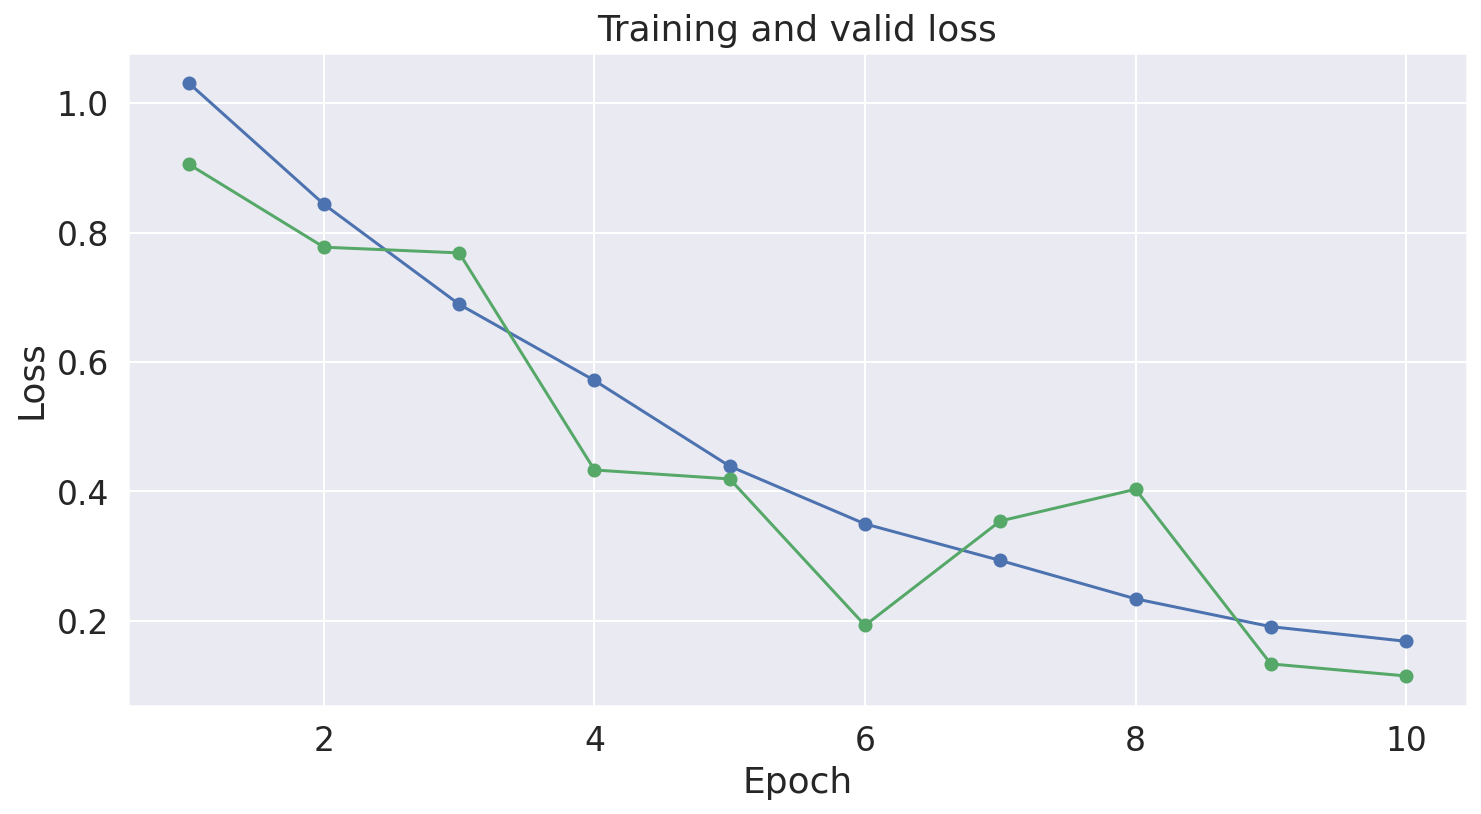

In [40]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

sns.set(style='darkgrid')

sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")


plt.title("Training and valid loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

In [41]:
model.eval()

prediction, true_labels = [], []

for batch in test_dataloader:
  batch = tuple(t.to(device) for t in batch)

  b_input_ids, b_input_mask, b_labels = batch

  with torch.no_grad():
    outputs = model(b_input_ids,
                    token_type_ids=None,
                    attention_mask=b_input_mask)
    
  logits = outputs[0]

  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  prediction.append(logits)
  true_labels.append(label_ids)

In [42]:
from sklearn.metrics import matthews_corrcoef

flat_prediction = [item for sublist in prediction for item in sublist]
flat_prediction = np.argmax(flat_prediction, axis=1).flatten()

flat_true_labels = [item for sublist in true_labels for item in sublist]

mcc = matthews_corrcoef(flat_true_labels, flat_prediction)

print("MCC: %.3f" %mcc)

MCC: 0.500


In [43]:
from sklearn.metrics import accuracy_score

acc = accuracy_score(flat_true_labels, flat_prediction)

print("ACC: %.3f" %acc)

ACC: 0.671


In [44]:
train_acc = df_stats['acc'].mean()

train_acc

0.6736328125

In [45]:
train_acc = df_stats['acc'].mean()
train_loss = df_stats['Training Loss'].mean()
val_loss = df_stats['Valid. Loss'].mean()

In [46]:
train_loss

0.4811840637222581

In [47]:
val_loss

0.45040507391095164

In [48]:
train_acc

0.6736328125

In [49]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import f1_score, precision_score, recall_score

In [50]:
print(confusion_matrix(flat_true_labels, flat_prediction))
print(classification_report(flat_true_labels, flat_prediction))
print('Recall: {}'.format(recall_score(flat_true_labels, flat_prediction,average='weighted')))
print('Precision: {}'.format(precision_score(flat_true_labels, flat_prediction,average='weighted')))
print('F1-Score: {}'.format(f1_score(flat_true_labels, flat_prediction,average='weighted')))

[[99 27 20]
 [24 59  8]
 [34 12 97]]
              precision    recall  f1-score   support

           0       0.63      0.68      0.65       146
           1       0.60      0.65      0.62        91
           2       0.78      0.68      0.72       143

    accuracy                           0.67       380
   macro avg       0.67      0.67      0.67       380
weighted avg       0.68      0.67      0.67       380

Recall: 0.6710526315789473
Precision: 0.6784668646137637
F1-Score: 0.6729886336368648
